<a href="https://colab.research.google.com/github/prikmm/Stock_predictor/blob/main/Stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
import os
import time
!pip install ta
import ta
import warnings
warnings.filterwarnings('ignore')
import tensorflow_datasets as tfds

  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=eae00d9b9c3498c05c7ca3c7eb572e5b699fcc7447ffe18b31e27db0bf4b4e2d
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [2]:
complete_stock_data_path = keras.utils.get_file("/content/all_stocks_data_JAN_2006_to_JAN_2018.csv",
                                                "https://raw.githubusercontent.com/prikmm/Stock_predictor/main/all_stocks_2006-01-01_to_2018-01-01.csv")

stock_data_2017_path = keras.utils.get_file("/content/all_stocks_data_JAN_2017_to_JAN_2018.csv",
                                            "https://raw.githubusercontent.com/prikmm/Stock_predictor/main/all_stocks_2017-01-01_to_2018-01-01.csv")

385024/379881 [==============================] - 0s 0us/step


In [3]:
print(complete_stock_data_path)
print(stock_data_2017_path)

/content/all_stocks_data_JAN_2006_to_JAN_2018.csv
/content/all_stocks_data_JAN_2017_to_JAN_2018.csv


In [4]:
complete_stock_df = pd.read_csv(complete_stock_data_path)
complete_stock_df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [5]:
complete_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93612 entries, 0 to 93611
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    93612 non-null  object 
 1   Open    93587 non-null  float64
 2   High    93602 non-null  float64
 3   Low     93592 non-null  float64
 4   Close   93612 non-null  float64
 5   Volume  93612 non-null  int64  
 6   Name    93612 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 5.0+ MB


In [6]:
stock_df = complete_stock_df.drop(columns="Volume")
stock_df.head()

,Date,Open,High,Low,Close,Name
0,2006-01-03,77.76,79.35,77.24,79.11,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,MMM


In [7]:
grouped_stock_df = stock_df.set_index(["Name", "Date"])
grouped_stock_df

Open   High    Low  Close
Name Date                                  
MMM  2006-01-03  77.76  79.35  77.24  79.11
     2006-01-04  79.49  79.49  78.25  78.71
     2006-01-05  78.41  78.65  77.56  77.99
     2006-01-06  78.64  78.90  77.64  78.63
     2006-01-09  78.50  79.83  78.46  79.02
...                ...    ...    ...    ...
AABA 2017-12-22  71.42  71.87  71.22  71.58
     2017-12-26  70.94  71.39  69.63  69.86
     2017-12-27  69.77  70.49  69.69  70.06
     2017-12-28  70.12  70.32  69.51  69.82
     2017-12-29  69.79  70.13  69.43  69.85

[93612 rows x 4 columns]

In [8]:
stock_names = stock_df['Name'].unique()
stock_names

array(['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS',
       'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK',
       'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT',
       'GOOGL', 'AMZN', 'AABA'], dtype=object)

### Creating Train, Valid and Test datasets from IBM data:

In [9]:
ibm_df = grouped_stock_df.loc['IBM'].copy()
ibm_df

,Open,High,Low,Close
Date,,,,
2006-01-03,82.45,82.55,80.81,82.06
2006-01-04,82.20,82.50,81.33,81.95
2006-01-05,81.40,82.90,81.00,82.50
2006-01-06,83.95,85.03,83.41,84.95
2006-01-09,84.10,84.25,83.38,83.73
...,...,...,...,...
2017-12-22,151.82,153.00,151.50,152.50
2017-12-26,152.51,153.86,152.50,152.83
2017-12-27,152.95,153.18,152.61,153.13


In [10]:
temp_ibm_df = ibm_df.reset_index()
masker = temp_ibm_df['Date'].str.split('-').str[0].astype(int)

# Train Set
train_df = temp_ibm_df[masker < 2016].copy()
train_df = train_df.set_index("Date")


# Valid Set
valid_df = temp_ibm_df[(masker >= 2016) & (masker < 2017)].copy()
valid_df = valid_df.set_index("Date")


# Test Set
test_df = temp_ibm_df[masker >= 2017].copy()
test_df = test_df.set_index("Date")


datasets_list = (('Train', train_df), 
                 ('Valid', valid_df), 
                 ('Test', test_df))

for Name, data in datasets_list:
    print(f"{'-'*20}{Name}{'-'*20}")
    print("Data---", data.shape)
    print(data.head())
    print(data.tail())
    print(f"End{'-'*60}"+"\n")

--------------------Train--------------------
Data--- (2517, 4)
             Open   High    Low  Close
Date                                  
2006-01-03  82.45  82.55  80.81  82.06
2006-01-04  82.20  82.50  81.33  81.95
2006-01-05  81.40  82.90  81.00  82.50
2006-01-06  83.95  85.03  83.41  84.95
2006-01-09  84.10  84.25  83.38  83.73
              Open    High     Low   Close
Date                                      
2015-12-24  138.43  138.88  138.11  138.25
2015-12-28  137.74  138.04  136.54  137.61
2015-12-29  138.25  140.06  138.20  139.78
2015-12-30  139.58  140.44  139.22  139.34
2015-12-31  139.07  139.10  137.57  137.62
End------------------------------------------------------------

--------------------Valid--------------------
Data--- (252, 4)
              Open    High     Low   Close
Date                                      
2016-01-04  135.60  135.97  134.24  135.95
2016-01-05  136.76  136.89  134.85  135.85
2016-01-06  134.38  135.58  133.62  135.17
2016-01-07  133.70 

## Visualization:

### Visualizing IBM data:

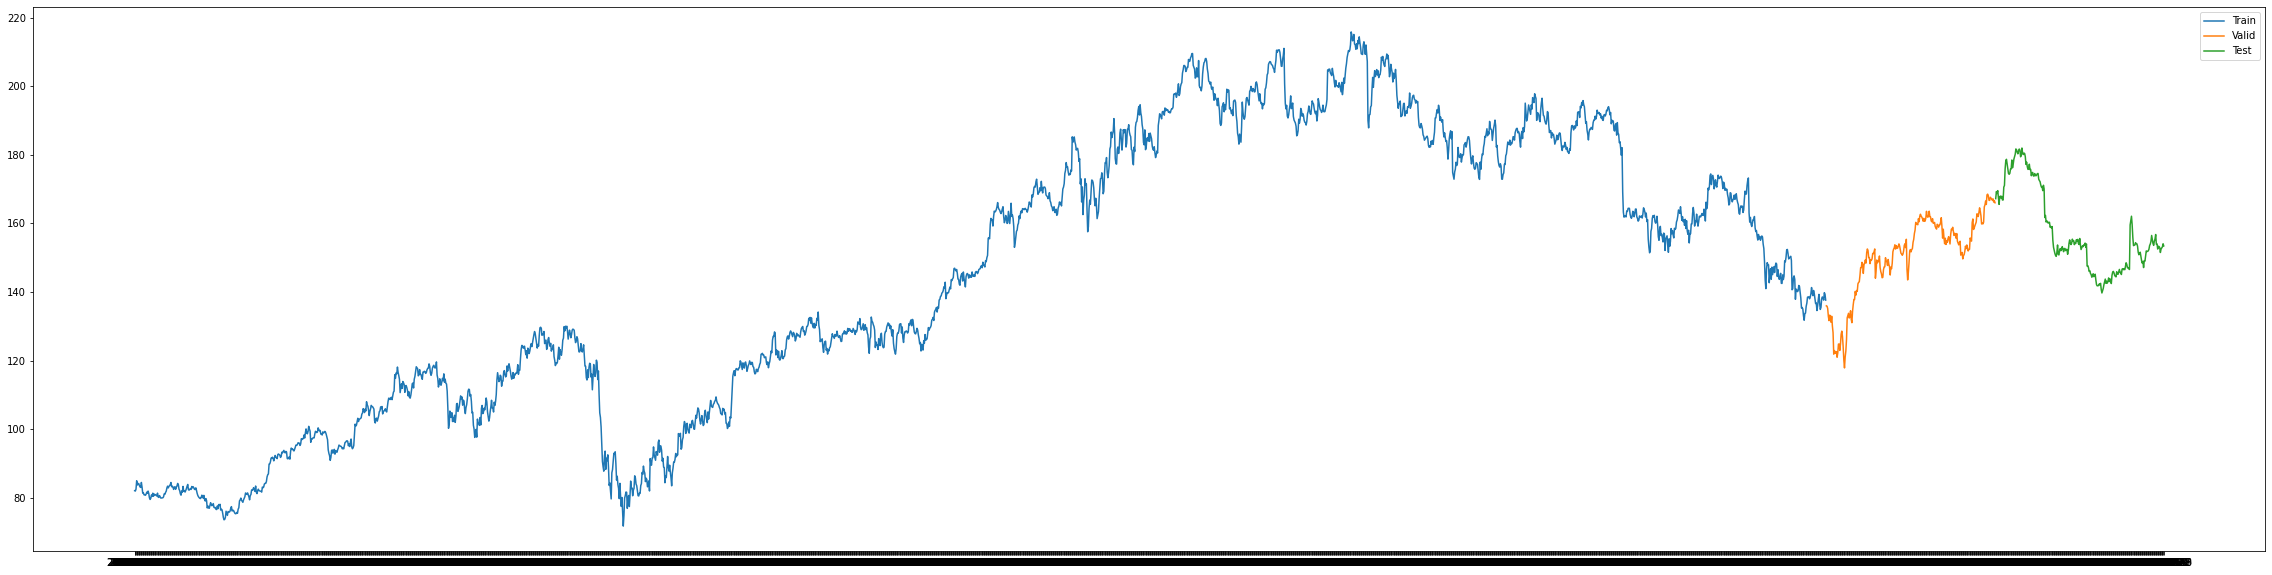

In [11]:
plt.figure(figsize=(40, 10))
plt.plot(train_df.index.get_level_values(0), train_df["Close"], label="Train")
plt.plot(valid_df.index.get_level_values(0), valid_df["Close"], label="Valid")
plt.plot(test_df.index.get_level_values(0), test_df["Close"], label="Test")
plt.legend()
plt.show()

***A company's stock price is not only dependent on the company's past     performance, but also on the performance of its competitors and many other factors like governmental policies, mergers etc. But, it is extremely difficult to make a model that can take into account all the possible factors. We will first make a model which will take into account a company's past performance, then TRY to create a model which will try to learn the dependency between different companies.***

#### Visualizing data of year 2017 of all stocks except "IBM":

In [12]:
data_2017 = pd.read_csv(stock_data_2017_path).set_index(["Name", "Date"]).drop(['IBM'])
data_2017

Open    High     Low   Close    Volume
Name Date                                                
MMM  2017-01-03  178.83  180.00  177.22  178.05   2510055
     2017-01-04  178.03  178.90  177.61  178.32   1541985
     2017-01-05  178.26  179.14  176.89  177.71   1447848
     2017-01-06  177.29  178.60  175.80  178.23   1625049
     2017-01-09  178.37  178.38  177.20  177.27   1622625
...                 ...     ...     ...     ...       ...
AABA 2017-12-22   71.42   71.87   71.22   71.58  10979165
     2017-12-26   70.94   71.39   69.63   69.86   8542802
     2017-12-27   69.77   70.49   69.69   70.06   6345124
     2017-12-28   70.12   70.32   69.51   69.82   7556877
     2017-12-29   69.79   70.13   69.43   69.85   6613070

[7530 rows x 5 columns]

In [13]:
extra_stock_names = stock_names[stock_names!='IBM']
extra_stock_names

array(['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS',
       'XOM', 'GE', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK',
       'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'WMT',
       'GOOGL', 'AMZN', 'AABA'], dtype=object)

In [14]:
fig = px.line(data_2017, x=data_2017.index.get_level_values(1), y="Close",
              color=data_2017.index.get_level_values(0),
              color_discrete_sequence=px.colors.qualitative.Alphabet,
              width=2000,
              height=1000)
fig.show()

#### Visualizing data from 2006 to 2018 of all stocks except IBM:

In [15]:
extra_data = grouped_stock_df.loc[extra_stock_names]

fig = px.line(extra_data, x=extra_data.index.get_level_values(1), y="Close",
              color=extra_data.index.get_level_values(0),
              color_discrete_sequence=px.colors.qualitative.Alphabet,
              width=2000,
              height=1000)
fig.show()

## Modelling:

In [16]:
from sklearn.preprocessing import MinMaxScaler
!pip install tensorflow_transform
import tensorflow_transform as tft

     |████████████████████████████████| 399kB 7.0MB/s 
     |████████████████████████████████| 17.7MB 203kB/s 
     |████████████████████████████████| 2.2MB 48.5MB/s 
     |████████████████████████████████| 9.0MB 51.1MB/s 
     |████████████████████████████████| 153kB 46.8MB/s 
     |████████████████████████████████| 2.2MB 49.2MB/s 
     |████████████████████████████████| 829kB 49.7MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 440kB 51.1MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 184kB 52.8MB/s 
     |████████████████████████████████| 153kB 54.5MB/s 
     |████████████████████████████████| 92kB 12.5MB/s 
     |████████████████████████████████| 256kB 58.8MB/s 
     |████████████████████████████████| 276kB 51.1MB/s 
     |████████████████████████████████| 174kB 58.4MB/s 
     |████████████████████████████████| 174kB 59.9MB/s 

In [17]:
def train_scaled_dataset_creator(data, window_size=30, batch_size=30):
   
    # Using a library known as "Technical Analysis" we will add Technical 
    # indicators, which the stock analysts use to predict
    # different properties of stock.
    # data = ta.add_all_ta_features(data, open="Open", high="High", 
    #                               low="Low", close="Close",
    #                               volume="Volume", fillna=True)
    
    scaler = MinMaxScaler()
    scaler.fit(data)
    scaling_params = {
        "min": tf.constant(scaler.data_min_),
        "range": tf.constant(scaler.data_range_),
    } 

    def scaler_func(window):
        window = tf.subtract(window, scaling_params["min"])
        window = tf.divide(window, scaling_params["range"])
        return window

    dataset = tf.data.Dataset.from_tensor_slices((data))
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda window: (scaler_func(window[:, :-1]), window[:, -1]))
    return dataset.prefetch(1), scaler


def complete_scaled_dataset_creator(data, window_size=30, batch_size=30):
   
    # Using a library known as "Technical Analysis" we will add Technical 
    # indicators, which the stock analysts use to predict
    # different properties of stock.
    # data = ta.add_all_ta_features(data, open="Open", high="High", 
    #                               low="Low", close="Close",
    #                               volume="Volume", fillna=True)
    
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)        
    dataset = tf.data.Dataset.from_tensor_slices((data))
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda window: (window[:, :-1], window[:, -1]))
    return dataset.prefetch(1), scaler

class Callbacks():
    def __init__(self, model_name, log_path="./log"):
        self.model_name = model_name
        self.log_path = log_path
        self.model_log_path = f'{self.log_path}/{self.model_name}'
        os.makedirs(self.model_log_path, exist_ok=True)
        self.model_run = 0

    def generate_log_name(self):
        self.model_run += 1
        return f'{self.model_log_path}/run_{self.model_run}'

    def get_callbacks(self, patience=5,):
        callbacks = [keras.callbacks.ModelCheckpoint(f'{self.model_name}.h5'),
                     keras.callbacks.EarlyStopping(patience=patience),
                     keras.callbacks.TensorBoard(self.generate_log_name())]
        
        return callbacks


class LastTimeStepMSE(keras.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mse_history = tf.TensorArray(tf.float32, size=0,
                                          dynamic_size=True,
                                          clear_after_read=False)
        self.count = 0

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])
        self.mse_history = self.mse_history.write(self.count, metric)
        self.count += 1
    
    def result(self):
        return self.mse_history.read(self.count-1)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [18]:
train_set, train_scaler = complete_scaled_dataset_creator(train_df)
for item in train_set.take(1):
    print(item)

(<tf.Tensor: shape=(30, 30, 4), dtype=float64, numpy=
array([[[0.06807347, 0.06065089, 0.07810773, 0.07163682],
        [0.06632081, 0.06029868, 0.0816989 , 0.07087325],
        [0.06071228, 0.06311637, 0.07941989, 0.0746911 ],
        ...,
        [0.05370163, 0.05297267, 0.07389503, 0.06656948],
        [0.06022154, 0.05614258, 0.07375691, 0.0603915 ],
        [0.05475322, 0.05290223, 0.07493094, 0.06490351]],

       [[0.06632081, 0.06029868, 0.0816989 , 0.07087325],
        [0.06071228, 0.06311637, 0.07941989, 0.0746911 ],
        [0.07858946, 0.0781206 , 0.09606354, 0.0916979 ],
        ...,
        [0.06022154, 0.05614258, 0.07375691, 0.0603915 ],
        [0.05475322, 0.05290223, 0.07493094, 0.06490351],
        [0.05692653, 0.05325444, 0.07596685, 0.06323754]],

       [[0.06071228, 0.06311637, 0.07941989, 0.0746911 ],
        [0.07858946, 0.0781206 , 0.09606354, 0.0916979 ],
        [0.07964105, 0.07262609, 0.09585635, 0.08322921],
        ...,
        [0.05475322, 0.05290223, 

Each batch consists of samples and each sample consists of timesteps (i.e days).

In [19]:
valid_set, valid_scaler = complete_scaled_dataset_creator(valid_df)
test_set, test_scaler = complete_scaled_dataset_creator(test_df)

for item in valid_set.take(1):
    print("X:--", item[0].shape)
    print("y:--", item[1].shape)

for item in test_set.take(1):
    print("X:--", item[0].shape)
    print("y:--", item[1].shape) 

valid_batch_count = 0
test_batch_count = 0
for _ in valid_set:
    valid_batch_count += 1

for _ in test_set:
    test_batch_count += 1

print(valid_batch_count, test_batch_count)

X:-- (30, 30, 4)
y:-- (30, 4)
X:-- (30, 30, 4)
y:-- (30, 4)
8 8


### 1. Model using past performance:

#### Using Non-Stationary Data:

##### Normal LSTM architeture:

In [20]:
lstm_nonst_callbacks = Callbacks("LSTM", "./logs/stationary/")

lstm_nonst_model = keras.models.Sequential([
    keras.layers.LSTM(50, input_shape=[None, 4], return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(150, return_sequences=True),
    keras.layers.LSTM(200),
    keras.layers.Dense(4)
])

lstm_nonst_model.compile(loss="mse",
                   optimizer=keras.optimizers.Nadam(),
                   metrics=[LastTimeStepMSE()])
lstm_nonst_history = lstm_nonst_model.fit(train_set, epochs=50,
                                          validation_data=valid_set,
                                          callbacks=lstm_nonst_callbacks.get_callbacks(10))

Epoch 1/50
83/83 [==============================] - 39s 45ms/step - loss: 0.0108 - last_time_step_mse: 0.0123 - val_loss: 0.0577 - val_last_time_step_mse: 0.1989
Epoch 2/50
83/83 [==============================] - 1s 16ms/step - loss: 0.0076 - last_time_step_mse: 0.0047 - val_loss: 0.0599 - val_last_time_step_mse: 0.2065
Epoch 3/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0038 - last_time_step_mse: 0.0033 - val_loss: 0.0629 - val_last_time_step_mse: 0.2153
Epoch 4/50
83/83 [==============================] - 1s 15ms/step - loss: 0.0026 - last_time_step_mse: 0.0031 - val_loss: 0.0640 - val_last_time_step_mse: 0.2199
Epoch 5/50
83/83 [==============================] - 1s 17ms/step - loss: 0.0027 - last_time_step_mse: 0.0034 - val_loss: 0.0632 - val_last_time_step_mse: 0.2198
Epoch 6/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0029 - last_time_step_mse: 0.0038 - val_loss: 0.0618 - val_last_time_step_mse: 0.2165
Epoch 7/50
83/83 [===============

In [21]:
lstm_nonst_model = keras.models.load_model("LSTM.h5", custom_objects={'LastTimeStepMSE': LastTimeStepMSE})
y_pred = lstm_nonst_model.predict(valid_set)
print(y_pred.shape)

(222, 4)


In [22]:
y_pred = valid_scaler.inverse_transform(y_pred)

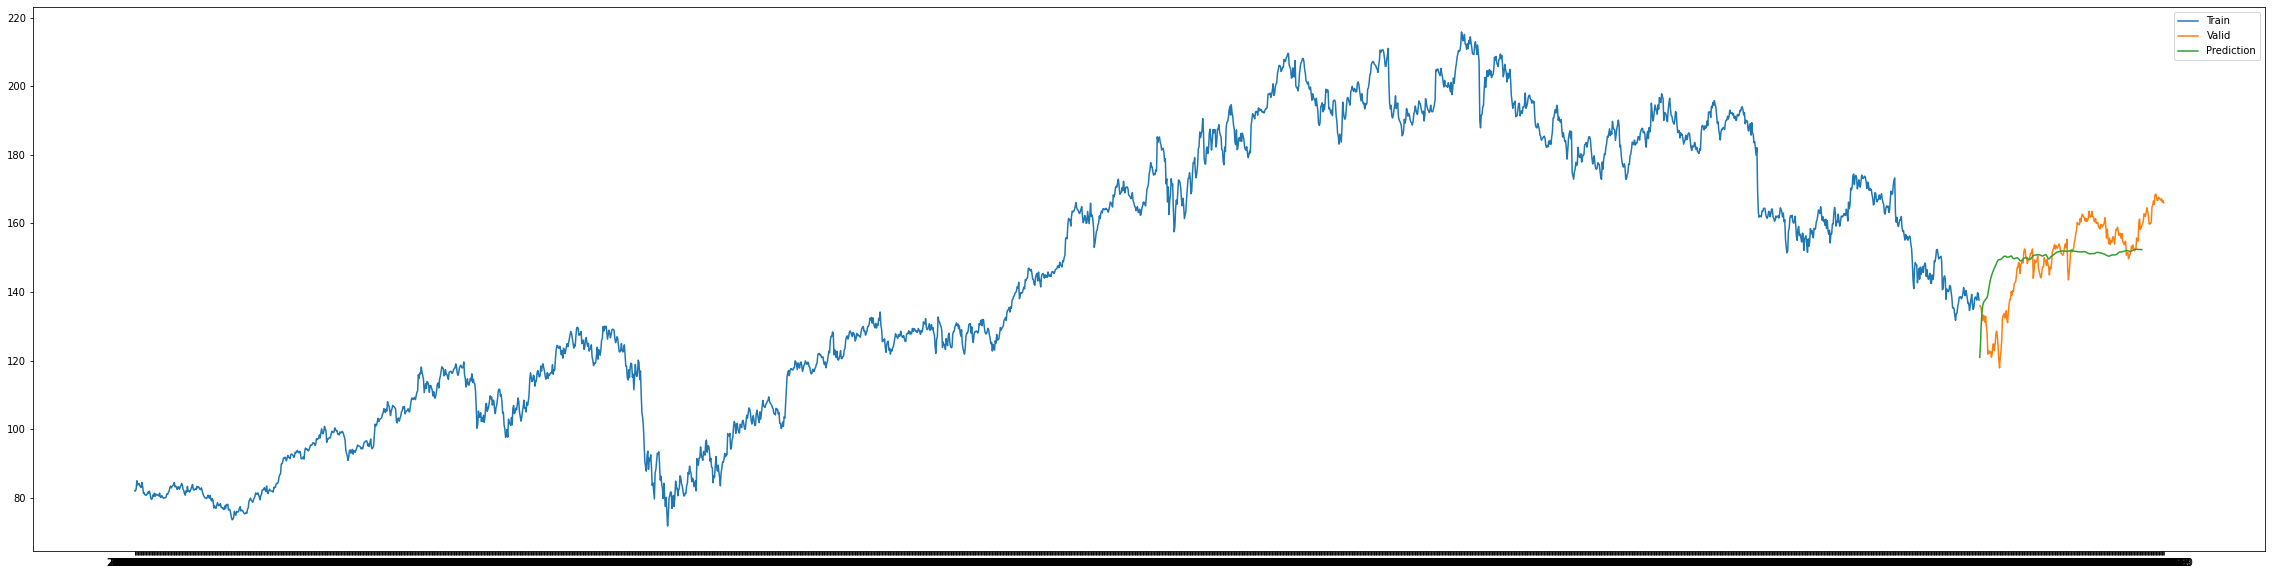

In [23]:
plt.figure(figsize=(40, 10))
plt.plot(train_df.index.get_level_values(0), train_df["Close"], label="Train")
plt.plot(valid_df.index.get_level_values(0), valid_df["Close"], label="Valid")
plt.plot(valid_df.index.get_level_values(0)[:222], y_pred[:, 3], label="Prediction")
plt.legend()
plt.show()

##### Normal GRU Architecture:

In [28]:
gru_nonst_callbacks = Callbacks("GRU", "./logs/stationary/")

gru_nonst_model = keras.models.Sequential([
    keras.layers.GRU(50, input_shape=[None, 4], return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.GRU(150, return_sequences=True),
    keras.layers.GRU(200),
    keras.layers.Dense(4)
])

gru_nonst_model.compile(loss="mse",
                        optimizer=keras.optimizers.Nadam(),
                        metrics=[LastTimeStepMSE()])
gru_nonst_history = lstm_nonst_model.fit(train_set, epochs=50,
                                         validation_data=valid_set,
                                         callbacks=gru_nonst_callbacks.get_callbacks(10))

Epoch 1/50
83/83 [==============================] - 2s 26ms/step - loss: 0.0103 - last_time_step_mse: 0.0047 - val_loss: 0.0740 - val_last_time_step_mse: 0.2316
Epoch 2/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0108 - last_time_step_mse: 0.0049 - val_loss: 0.0729 - val_last_time_step_mse: 0.2296
Epoch 3/50
83/83 [==============================] - 1s 18ms/step - loss: 0.0112 - last_time_step_mse: 0.0050 - val_loss: 0.0719 - val_last_time_step_mse: 0.2283
Epoch 4/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0115 - last_time_step_mse: 0.0051 - val_loss: 0.0710 - val_last_time_step_mse: 0.2272
Epoch 5/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0119 - last_time_step_mse: 0.0052 - val_loss: 0.0701 - val_last_time_step_mse: 0.2261
Epoch 6/50
83/83 [==============================] - 1s 16ms/step - loss: 0.0122 - last_time_step_mse: 0.0054 - val_loss: 0.0692 - val_last_time_step_mse: 0.2247
Epoch 7/50
83/83 [================

In [25]:
gru_nonst_model = keras.models.load_model("GRU.h5", custom_objects={'LastTimeStepMSE': LastTimeStepMSE})
y_pred = gru_nonst_model.predict(valid_set)
print(y_pred.shape)

(222, 4)


In [26]:
y_pred = valid_scaler.inverse_transform(y_pred)

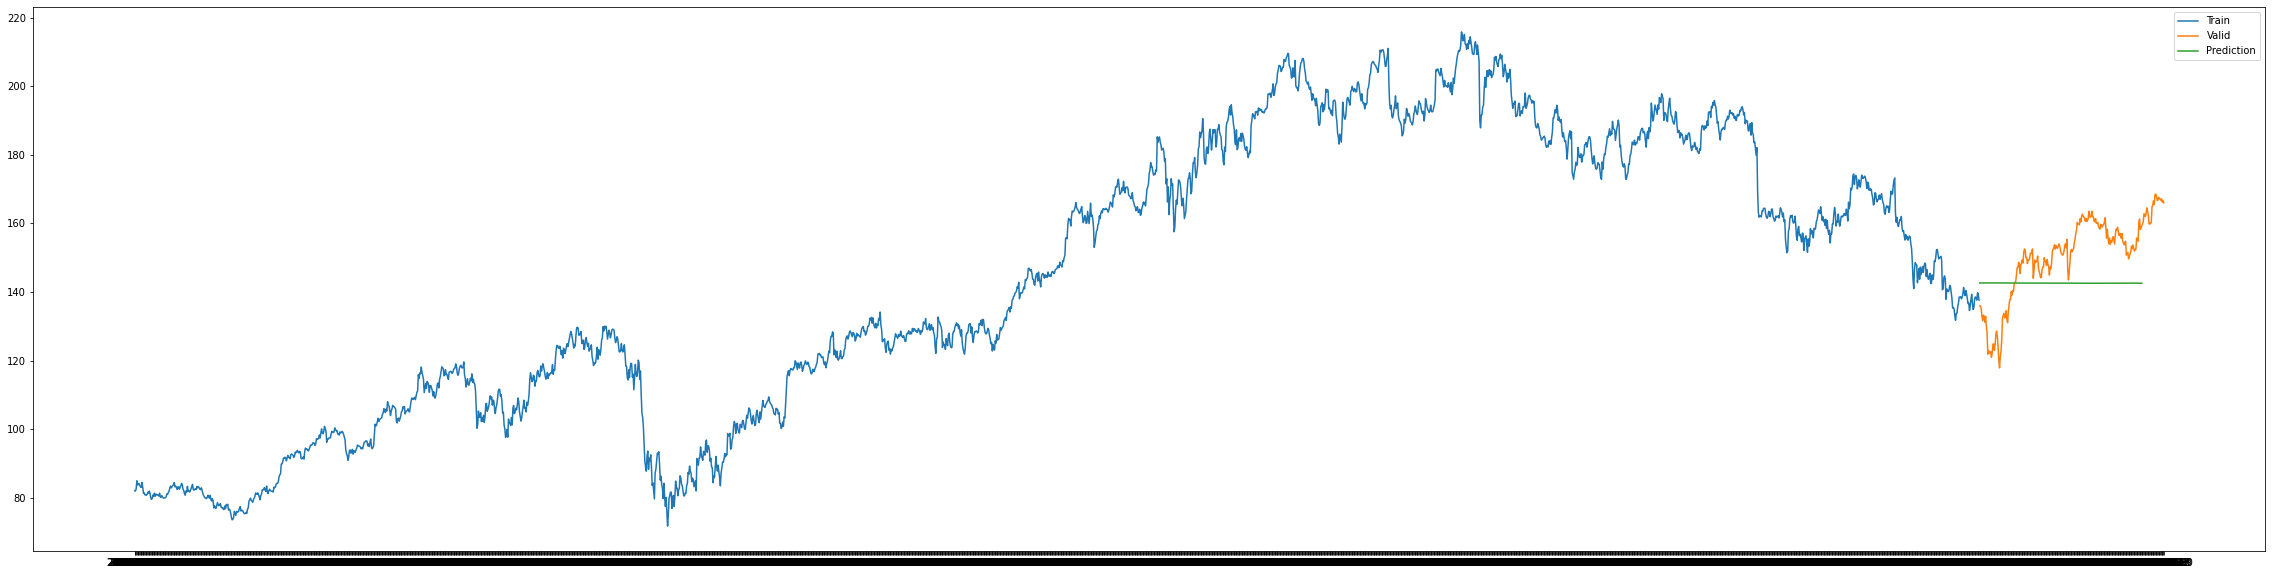

In [27]:
plt.figure(figsize=(40, 10))
plt.plot(train_df.index.get_level_values(0), train_df["Close"], label="Train")
plt.plot(valid_df.index.get_level_values(0), valid_df["Close"], label="Valid")
plt.plot(valid_df.index.get_level_values(0)[:222], y_pred[:, 3], label="Prediction")
plt.legend()
plt.show()